In [ ]:
! youtube_dl.sh
! mkdir audio_rename

In [1]:
from shutil import copyfile
from glob import glob
from tqdm.notebook import tqdm
names = sorted(glob('audio_dl/*/*mp3'))
for name in tqdm(names):
    src = name
    dst = 'audio_rename/'+name[-15:]
    copyfile(src, dst)

In [ ]:
! re_sample.py
! label.py

In [1]:
import torch
import torchaudio
from glob import glob 
from tqdm import tqdm
names = sorted(glob('audio_22050/*mp3'))

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [158]:
X = {}
for c in tqdm(range(500)):
    ID = names[c].split('/')[1][:-4]
    waveform_, sample_rate = torchaudio.load(names[c])
    X[ID] = waveform_[0]

100%|██████████| 500/500 [03:20<00:00,  2.50it/s]


In [159]:
torch.save(X,'audio_small.pt')

In [1]:
import torch
data = torch.load('audio_mini.pt')
IDs = list(data.keys())

In [3]:
import numpy as np
import torch
from tqdm.notebook import tqdm 
from torch.nn import ConstantPad1d
from glob import glob

def LB(y):  # label方式更改
    for i in range(1,len(y)):
        if y[i] != 0:
            y[i] = y[i-1] + y[i]
    return y/y.max()

rate = 22050
window_size = 6 #sec
shift_size = 1 #sec

typs = ['T','N']
dic = {k:v for v,k in enumerate(typs)}

xss = torch.LongTensor([])
yss = torch.LongTensor([])

g = 0
groups = np.array([])

for i in tqdm(range(0,50,25)):
    xs = torch.LongTensor([])
    ys = torch.LongTensor([])
    group = np.array([])
    
    for ii in range(i,i+25):
        
        pad_len = (window_size/2)*rate
        pad = ConstantPad1d(int(pad_len),0)
        waveform = pad(data[IDs[ii]])

        #make a sliding window 
        x = waveform.unfold(dimension = 0,
                                 size = window_size*rate,
                                 step =shift_size*rate).unsqueeze(1)

        #get labels
        f = open('label/'+IDs[ii]+'.txt')
        txts = f.readlines()
        c = []
        i = 0
        for txt in txts:
            tmp = txt.split()
            typs = dic.get(tmp[2].replace('\n',''))
            start = float(tmp[0])
            end = float(tmp[1])
            while start <= i < end:
                #print(start,end,i,typs)
                c.append(typs)
                i += shift_size
        y = torch.LongTensor(c)
        f.close()

        #make label and musiz len is same
        if x.shape[0] > y.shape[0]:
            x = x[:y.shape[0]]
        if y.shape[0] > x.shape[0]:
            y = y[:x.shape[0]]

        #make a group for GroupShuffleSplit
        group = np.append(group,np.repeat(g,y.shape[0]))
        g += 1

        #extand 
        xs = torch.cat((xs,x))
        ys = torch.cat((ys,LB(y)))
    xss = torch.cat((xss,xs))
    yss = torch.cat((yss,ys))
    groups = np.append(groups,group)

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [4]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=2, train_size=.8, random_state=42)

for train_index, test_index in gss.split(xss, yss, groups):
    X_train, X_test = xss[train_index], xss[test_index]
    y_train, y_test = yss[train_index], yss[test_index]

In [5]:
from torch.utils.data import DataLoader
dataloader_X_train = DataLoader(X_train,batch_size=64,shuffle=False, num_workers=0,drop_last=True)
dataloader_y_train= DataLoader(y_train,batch_size=64,shuffle=False, num_workers=0,drop_last=True)

dataloader_X_test = DataLoader(X_test,batch_size=64,shuffle=False, num_workers=0,drop_last=True)
dataloader_y_test= DataLoader(y_test,batch_size=64,shuffle=False, num_workers=0,drop_last=True)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram

class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
        
        self.fft = MelSpectrogram() #Fast Fourier Transform featrue = 128   
        
        cnn = nn.Sequential()
        cnn.add_module('conv{0}',   nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]))
        cnn.add_module('norm{0}',   nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        cnn.add_module('relu{0}',   nn.ELU(alpha=1.0))
        cnn.add_module('pooling{0}',nn.MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False))
        cnn.add_module('drop{0}',   nn.Dropout(p=0.1))
                       
        cnn.add_module('conv{1}',   nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]))
        cnn.add_module('norm{1}',   nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        cnn.add_module('relu{1}',   nn.ELU(alpha=1.0))
        cnn.add_module('pooling{1}',nn.MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False))
        cnn.add_module('drop{1}',   nn.Dropout(p=0.1))
     
        cnn.add_module('conv{2}',   nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]))        
        cnn.add_module('norm{2}',   nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        cnn.add_module('relu{2}',   nn.ELU(alpha=1.0))
        cnn.add_module('pooling{2}',nn.MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False))
        cnn.add_module('drop{2}',   nn.Dropout(p=0.1))
        self.cnn=cnn
        
        self.LSTM        = nn.LSTM(input_size = 13,hidden_size = 256,num_layers=7,bidirectional=True) #input_size change buy windows size
        self.Dropout     = nn.Dropout(p=0.1)
        self.BatchNorm1d = nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.Linear      = nn.Linear(in_features=512 , out_features=10, bias=True)
        self.Linear2     = nn.Linear(in_features=1280 , out_features=128, bias=True)
        self.Linear3     = nn.Linear(in_features=128 , out_features=1, bias=True)  #category number 
    
    def forward(self, x):                      #(seq)
        x   = self.fft(x)                      #(batch,1,seq)
        x   = self.cnn(x)                      #(batch,chanel,featrue,seq)
        x   = x.flatten(start_dim=1,end_dim=2) #(batch,chanel*featrue,seq)
        x   = x.transpose(0,1)                 #(seq,batch,chanel*featrue)
        x,_ = self.LSTM(x)                     #(seq,batch,64)
        x   = self.Dropout(x)                  #(seq,batch,64)
        x   = x.transpose(0,1)                 #(batch,seq,64)
        x   = x.transpose(1,2)                 #(batch,64,seq)
        x   = self.BatchNorm1d(x)              #(batch,64,seq)
        x   = x.transpose(1,2)                 #(batch,seq,64)      
        x   = self.Linear(x)                   #(batch,seq,10)
        x   = x.flatten(start_dim=1)           #(batch,seq*10)
        x   = self.Linear2(x)                  #(batch,128)
        x   = self.Linear3(x)                  #(batch,10)
        return x                               #(batch,10)

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [26]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.cuda.get_device_name(0)

'Tesla V100-PCIE-16GB'

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

In [29]:
!rm -rf runs/
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

from tqdm.notebook import tqdm 
from torch import optim
from sklearn.metrics import f1_score,confusion_matrix
model = CRNN().to(device)
loss_fn = nn.MSELoss()
learning_rate = 1e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
score_trains,score_vals = [],[]
best_loss = 10000
er = 0
epoch = 0
while er <=50 :
    epoch += 1
    t_loss = 0
    for batch_num,(x,y) in enumerate(zip(dataloader_X_train,dataloader_y_train)):
        model.train()
        output = model(x.to(device))
        loss = loss_fn(output, y.to(device))
        if torch.flatten(torch.isnan(loss)).any():
            continue
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t_loss += loss
    writer.add_scalar("Loss/train", t_loss/batch_num, epoch)
    score = float(t_loss/batch_num)
    score_trains.append(score)
    print('epoch',epoch,'train:',round(score,5),end=' ')
    
    t_loss_v = 0
    for batch_num,(x,y) in enumerate(zip(dataloader_X_test,dataloader_y_test)):
        model.eval()
        with torch.no_grad():
            output = model(x.to(device))
        loss = loss_fn(output, y.to(device))
        t_loss_v += loss
            
    writer.add_scalar("Loss/val", t_loss_v/batch_num, epoch)
    score_val = float(t_loss_v/batch_num)
    score_vals.append(score_val)
    print('val:',round(score_val,5))
    
    if score_val < best_loss: 
        best_loss = score_val
        torch.save(model.state_dict(), 'model/best_model'+str(epoch)+'.pt')
        er = 0
    else : 
        er += 1
print('stop at epoch:',epoch)

RuntimeError: CUDA out of memory. Tried to allocate 650.00 MiB (GPU 0; 15.78 GiB total capacity; 8.12 GiB already allocated; 379.50 MiB free; 8.96 GiB reserved in total by PyTorch)

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(score_trains)
plt.plot(score_vals)
#plt.savefig('ep1000_6_3_group.png')

NameError: name 'score_trains' is not defined

<Figure size 1080x360 with 0 Axes>

In [31]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [20]:
data[IDs[20]].shape

torch.Size([5591232])

In [21]:
5591232/22050

253.57061224489797

In [7]:
ii = 20

rate = 22050
window_size = 6 #sec
shift_size = 1 #sec

x = data[IDs[ii]].unfold(dimension = 0,
                         size = window_size*rate,
                         step =shift_size*rate).unsqueeze(1)

In [8]:
x.shape

torch.Size([248, 1, 132300])

In [ ]:
#get labels
f = open('label/'+IDs[ii]+'.txt')
txts = f.readlines()
c = []
i = 0
for txt in txts:
    tmp = txt.split()
    typs = dic.get(tmp[2].replace('\n',''))
    start = float(tmp[0])
    end = float(tmp[1])
    while start <= i < end:
        #print(start,end,i,typs)
        c.append(typs)
        i += shift_size
y = torch.LongTensor(c)
f.close()

In [4]:
model = CRNN()

/opt/conda/lib/python3.7/site-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [5]:
model.load_state_dict(torch.load('model/best_model28.pt'))

<All keys matched successfully>

In [9]:
out = model(x)

/opt/conda/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/opt/conda/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


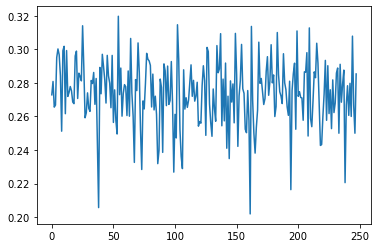

In [17]:
plt.plot(out.flatten().tolist())

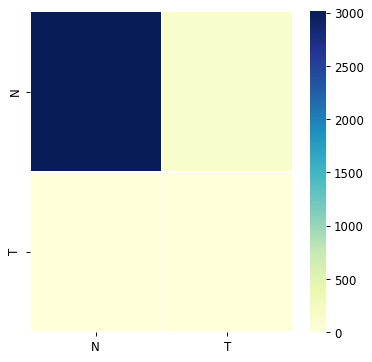

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5),dpi=85)
sns.heatmap(df,linewidths=.5,cmap="YlGnBu")

In [110]:
confusion_matrix(pre,tru)

array([[3013,  123],
       [   0,    0]])